<a href="https://colab.research.google.com/github/DJCordhose/ml-resources/blob/main/notebooks/foundation/transformers-fine-tuning-yelp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transformers fine tuning on YELP for sentiment

* Derived from: https://colab.research.google.com/github/huggingface/notebooks/blob/main/transformers_doc/en/tensorflow/training.ipynb#
* https://huggingface.co/transformers/training.html
  * https://huggingface.co/transformers/training.html#fine-tuning-with-keras
* https://huggingface.co/datasets/yelp_review_full
  * https://huggingface.co/docs/datasets/
    * https://github.com/huggingface/datasets


## Installation

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

figsize_3d = (20, 10)

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

'2.8.0'

In [17]:
tf.random.set_seed(42)

In [16]:
!nvidia-smi

Tue Apr 26 09:23:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    30W /  70W |  14226MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# https://huggingface.co/transformers/installation.html
# !pip install -q transformers 

In [ ]:
# https://huggingface.co/docs/datasets/installation.html
# !pip install -q datasets

In [1]:
# Transformers installation
! pip install transformers datasets
# To install from source instead of the last release, comment the command above and uncomment the following one.
# ! pip install git+https://github.com/huggingface/transformers.git

# Fine-tune a pretrained model

There are significant benefits to using a pretrained model. It reduces computation costs, your carbon footprint, and allows you to use state-of-the-art models without having to train one from scratch. 🤗 Transformers provides access to thousands of pretrained models for a wide range of tasks. When you use a pretrained model, you train it on a dataset specific to your task. This is known as fine-tuning, an incredibly powerful training technique. In this tutorial, you will fine-tune a pretrained model with a deep learning framework of your choice:

* Fine-tune a pretrained model with 🤗 Transformers [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer).
* Fine-tune a pretrained model in TensorFlow with Keras.
* Fine-tune a pretrained model in native PyTorch.

<a id='data-processing'></a>

## Prepare a dataset

In [2]:
#@title
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/_BZearw7f0w?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

Before you can fine-tune a pretrained model, download a dataset and prepare it for training. The previous tutorial showed you how to process data for training, and now you get an opportunity to put those skills to the test!

Begin by loading the [Yelp Reviews](https://huggingface.co/datasets/yelp_review_full) dataset:

In [3]:
from datasets import load_dataset

dataset = load_dataset("yelp_review_full")
dataset["train"][100]

Reusing dataset yelp_review_full (/root/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf)


  0%|          | 0/2 [00:00<?, ?it/s]

{'label': 0,
 'text': 'My expectations for McDonalds are t rarely high. But for one to still fail so spectacularly...that takes something special!\\nThe cashier took my friends\'s order, then promptly ignored me. I had to force myself in front of a cashier who opened his register to wait on the person BEHIND me. I waited over five minutes for a gigantic order that included precisely one kid\'s meal. After watching two people who ordered after me be handed their food, I asked where mine was. The manager started yelling at the cashiers for \\"serving off their orders\\" when they didn\'t have their food. But neither cashier was anywhere near those controls, and the manager was the one serving food to customers and clearing the boards.\\nThe manager was rude when giving me my order. She didn\'t make sure that I had everything ON MY RECEIPT, and never even had the decency to apologize that I felt I was getting poor service.\\nI\'ve eaten at various McDonalds restaurants for over 30 years. 

As you now know, you need a tokenizer to process the text and include a padding and truncation strategy to handle any variable sequence lengths. To process your dataset in one step, use 🤗 Datasets [`map`](https://huggingface.co/docs/datasets/process.html#map) method to apply a preprocessing function over the entire dataset:

In [4]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_datasets = dataset.map(tokenize_function, batched=True)

Loading cached processed dataset at /root/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf/cache-6791f8bb2a3d8782.arrow


  0%|          | 0/50 [00:00<?, ?ba/s]

If you like, you can create a smaller subset of the full dataset to fine-tune on to reduce the time it takes:

In [5]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf/cache-bcad8f3b8a15b1bb.arrow


<a id='trainer'></a>

## Train

<a id='keras'></a>

In [6]:
#@title
from IPython.display import HTML

HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/rnTGBy2ax1c?rel=0&amp;controls=0&amp;showinfo=0" frameborder="0" allowfullscreen></iframe>')

🤗 Transformers models also supports training in TensorFlow with the Keras API.

### Convert dataset to TensorFlow format

The [DefaultDataCollator](https://huggingface.co/docs/transformers/main/en/main_classes/data_collator#transformers.DefaultDataCollator) assembles tensors into a batch for the model to train on. Make sure you specify `return_tensors` to return TensorFlow tensors:

In [7]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator(return_tensors="tf")

<Tip>

[Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) uses [DataCollatorWithPadding](https://huggingface.co/docs/transformers/main/en/main_classes/data_collator#transformers.DataCollatorWithPadding) by default so you don't need to explicitly specify a data collator.

</Tip>

Next, convert the tokenized datasets to TensorFlow datasets with the [`to_tf_dataset`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasets.Dataset.to_tf_dataset) method. Specify your inputs in `columns`, and your label in `label_cols`:

In [8]:
tf_train_dataset = small_train_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

tf_validation_dataset = small_eval_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols=["label"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)

### Compile and fit

Load a TensorFlow model with the expected number of labels:

In [9]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Then compile and fine-tune your model with [`fit`](https://keras.io/api/models/model_training_apis/) as you would with any other Keras model:

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)

history = model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=5)

Epoch 1/5
125/125 [==============================] - 177s 1s/step - loss: 1.6337 - sparse_categorical_accuracy: 0.2080 - val_loss: 1.6377 - val_sparse_categorical_accuracy: 0.1660
Epoch 2/5
125/125 [==============================] - 162s 1s/step - loss: 1.6236 - sparse_categorical_accuracy: 0.2060 - val_loss: 1.6099 - val_sparse_categorical_accuracy: 0.2740
Epoch 3/5
125/125 [==============================] - 162s 1s/step - loss: 1.5558 - sparse_categorical_accuracy: 0.2970 - val_loss: 1.3974 - val_sparse_categorical_accuracy: 0.4000
Epoch 4/5
125/125 [==============================] - 162s 1s/step - loss: 1.3923 - sparse_categorical_accuracy: 0.3790 - val_loss: 1.4076 - val_sparse_categorical_accuracy: 0.3610
Epoch 5/5
125/125 [==============================] - 160s 1s/step - loss: 1.2018 - sparse_categorical_accuracy: 0.4890 - val_loss: 1.2493 - val_sparse_categorical_accuracy: 0.4440


<a id='pytorch_native'></a>

In [11]:
model.evaluate(tf_train_dataset)

125/125 [==============================] - 45s 337ms/step - loss: 1.0047 - sparse_categorical_accuracy: 0.5940


[1.0046714544296265, 0.593999981880188]

In [12]:
# training data set too small to not overfit on it
model.evaluate(tf_validation_dataset)

125/125 [==============================] - 43s 340ms/step - loss: 1.2493 - sparse_categorical_accuracy: 0.4440


[1.2492610216140747, 0.4440000057220459]

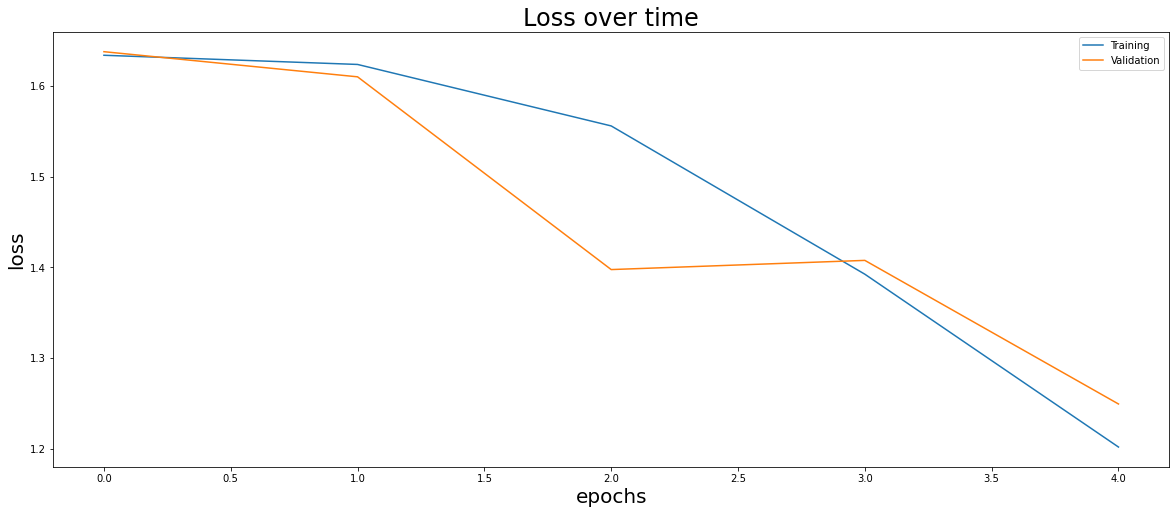

In [18]:
# plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);

plt.legend(['Training', 'Validation']);

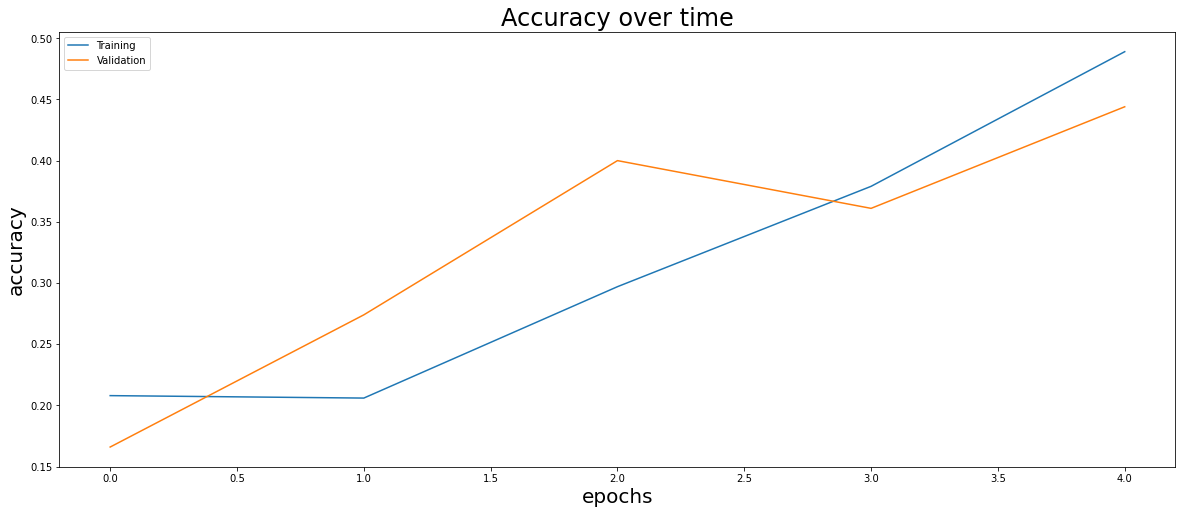

In [19]:
# plt.yscale('log')
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['sparse_categorical_accuracy']);
plt.plot(history.history['val_sparse_categorical_accuracy']);

plt.legend(['Training', 'Validation']);


## Additional resources

## Installation

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

figsize_3d = (20, 10)

In [ ]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
tf.__version__

'2.8.0'

In [ ]:
tf.random.set_seed(42)

In [ ]:
!nvidia-smi

Tue Apr 26 08:13:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# https://huggingface.co/transformers/installation.html
!pip install -q transformers 

In [ ]:
# https://huggingface.co/docs/datasets/installation.html
!pip install -q datasets

For more fine-tuning examples, refer to:

- [🤗 Transformers Examples](https://github.com/huggingface/transformers/tree/main/examples) includes scripts
  to train common NLP tasks in PyTorch and TensorFlow.

- [🤗 Transformers Notebooks](https://huggingface.co/docs/transformers/main/en/notebooks) contains various notebooks on how to fine-tune a model for specific tasks in PyTorch and TensorFlow.